In [1]:
import numpy as np

import scipy.fftpack as spfft
from sklearn.linear_model import Lasso

import matplotlib
import matplotlib.pyplot as plt

In [2]:
top_left = np.load("50x50_top_left.npy")
top_right = np.load("50x50_top_right.npy")
bottom_left = np.load("50x50_bottom_left.npy")
center = np.load("50x50_center.npy")

In [3]:
ny, nx = top_left.shape

In [4]:
ny, nx

(2500, 4)

In [5]:
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )

def cs_predict(qtable, sample_ratio=0.1, alpha=1E-5):

    # Reconstruct qtable
    X = qtable
    ny, nx = X.shape
    
    # extract small sample of signal
    k = int(np.round(nx * ny * sample_ratio))
    
    # state_action_distribution = learner.visits/np.sum(learner.visits)
    # SAdist_sorted = np.sort(state_action_distribution.flatten())
    # threshold_prob = SAdist_sorted[int(np.floor((1-sample_ratio)*len(SAdist_sorted)))]
    # ri = np.where(state_action_distribution.flatten() > threshold_prob)[0]
    
    ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
    b = X.T.flat[ri]
    b = np.expand_dims(b, axis=1)

    # compression matrix @ transform matrix
    Ac = A[ri,:] # same as phi times kron

    lasso = Lasso(alpha)
    lasso.fit(Ac, b)

    # Reconstruct qtable
    Xat = np.array(lasso.coef_).reshape(nx, ny).T # stack columns
    # Get the reconstructed qtable
    Xa = idct2(Xat)

    return Xa

def idct2(x):
        return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

In [6]:
def viz_qtable(qtable, description):
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    no_of_states, no_of_actions = qtable.shape
    mapdim = int(np.sqrt(no_of_states))
    # https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
    fig, axes = plt.subplots(nrows=1, ncols=no_of_actions, figsize=(16, 4))
    cmap = matplotlib.colormaps['winter']
    # normalizer = matplotlib.colors.Normalize(vmin=-2, vmax=2)
    normalizer = matplotlib.colors.Normalize()
    im = matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap)
    
    for i,ax in enumerate(axes):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.title.set_text(directions[i])
        im = ax.imshow(qtable[:,i].reshape(mapdim,mapdim),
                       cmap=cmap,
                       norm=normalizer)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # fig.colorbar(im, cax=cbar_ax)
    fig.colorbar(im, ax=axes.ravel().tolist())
    fig.suptitle(description, fontsize=10)
    plt.show()

In [7]:
from numpy.random import default_rng

rng = default_rng()

no_of_qtables = 4

measurement_array_length = ny*nx
shuffled_indices = rng.choice(measurement_array_length, 
                              size=measurement_array_length, 
                              replace=False)

In [8]:
border = int(len(shuffled_indices)/no_of_qtables)
top_left_ri = shuffled_indices[0:border]
top_right_ri = shuffled_indices[border:2*border]
bottom_left_ri = shuffled_indices[2*border:3*border]
center_ri = shuffled_indices[3*border:]

In [9]:
b_top_left = top_left.flat[top_left_ri].reshape(-1,1)
b_top_right = top_left.flat[top_right_ri].reshape(-1,1)
b_bottom_left = top_left.flat[bottom_left_ri].reshape(-1,1)
b_center = top_left.flat[center_ri].reshape(-1,1)

In [10]:
b = np.vstack((b_top_left, b_top_right, b_bottom_left, b_center))

In [11]:
# compression matrix @ transform matrix

lasso = Lasso(alpha=1E-5)
lasso.fit(A, b)

# Reconstruct qtable
Xat = np.array(lasso.coef_).reshape(nx, ny).T # stack columns
# Get the reconstructed qtable
Xa = idct2(Xat)

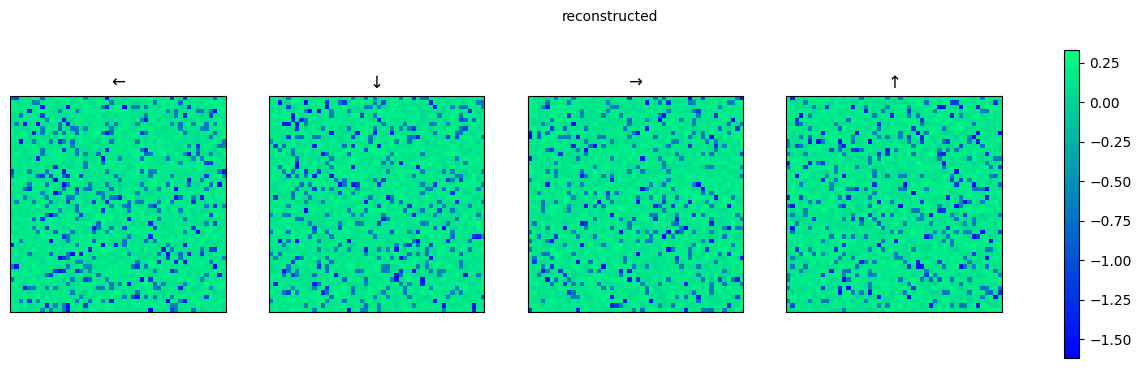

In [12]:
viz_qtable(Xa, "reconstructed")

In [13]:
b.shape

(10000, 1)

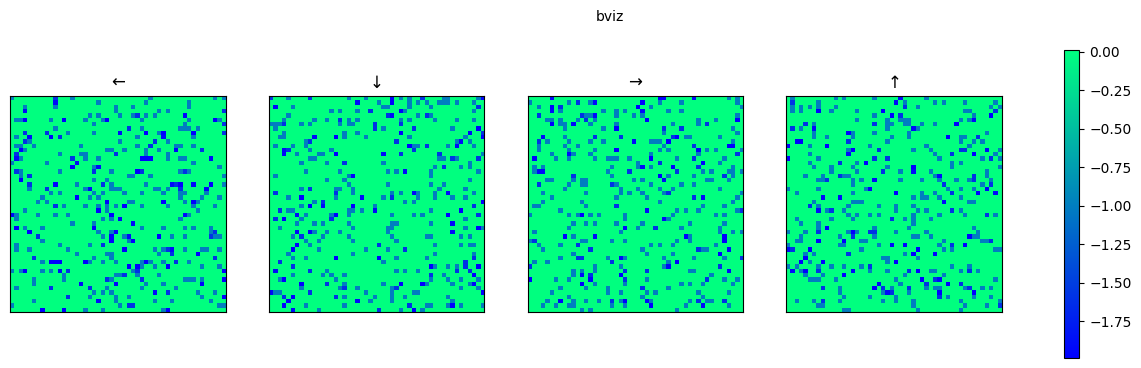

In [14]:
viz_qtable(b.reshape(-1,4), "bviz")

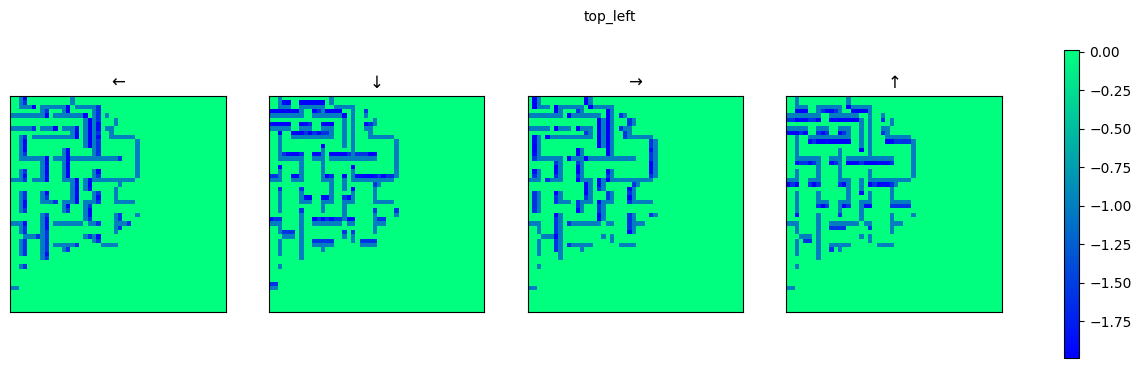

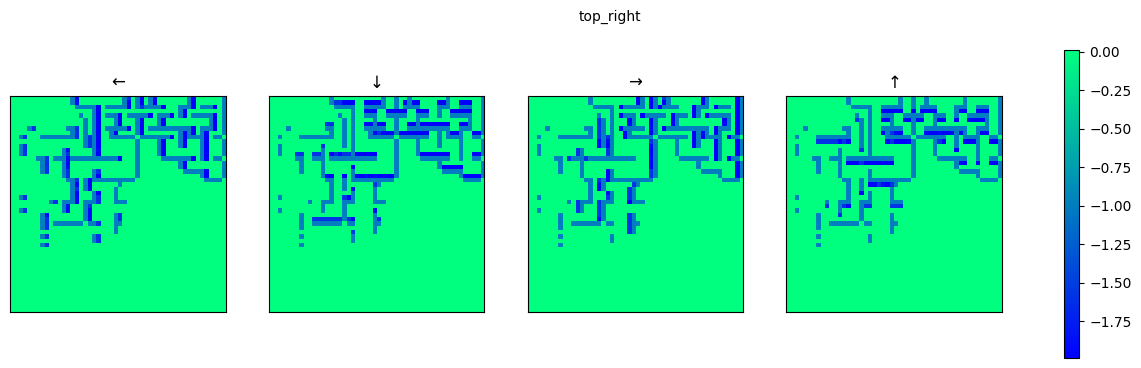

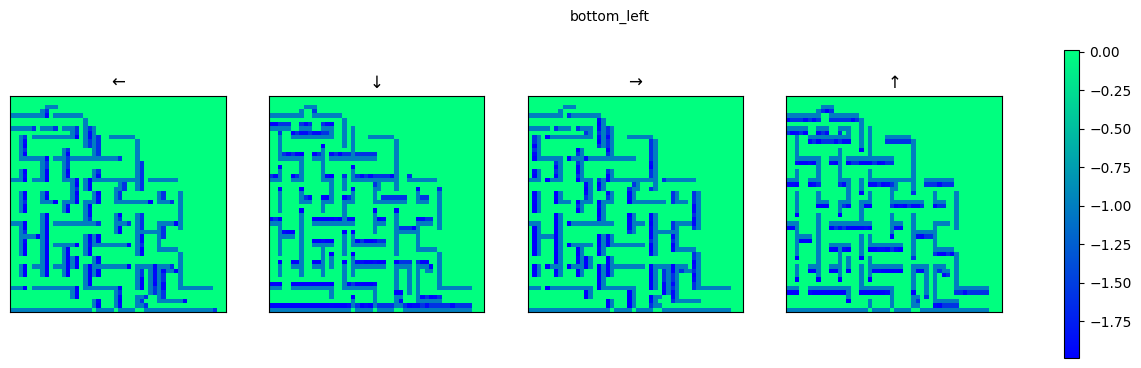

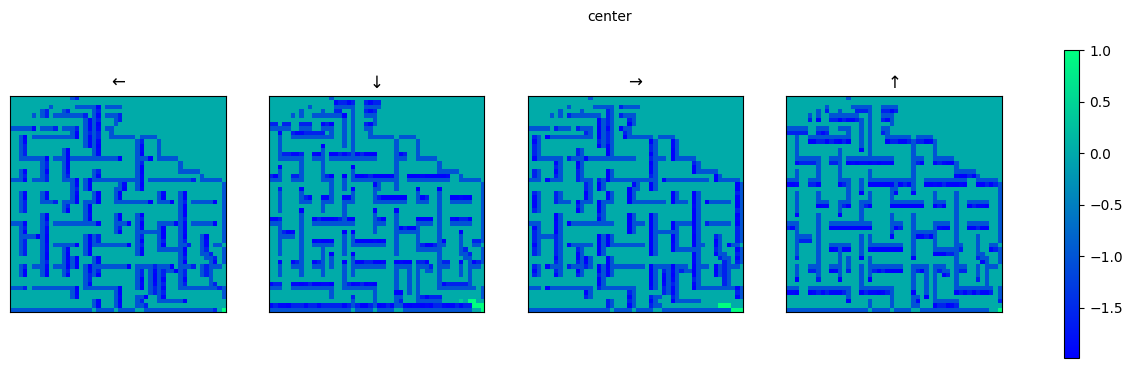

In [15]:
viz_qtable(top_left, "top_left")
viz_qtable(top_right, "top_right")
viz_qtable(bottom_left, "bottom_left")
viz_qtable(center, "center")

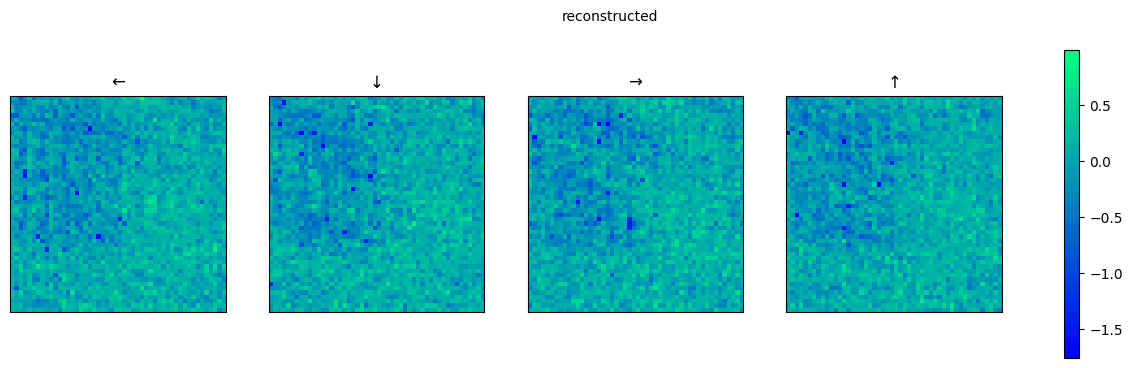

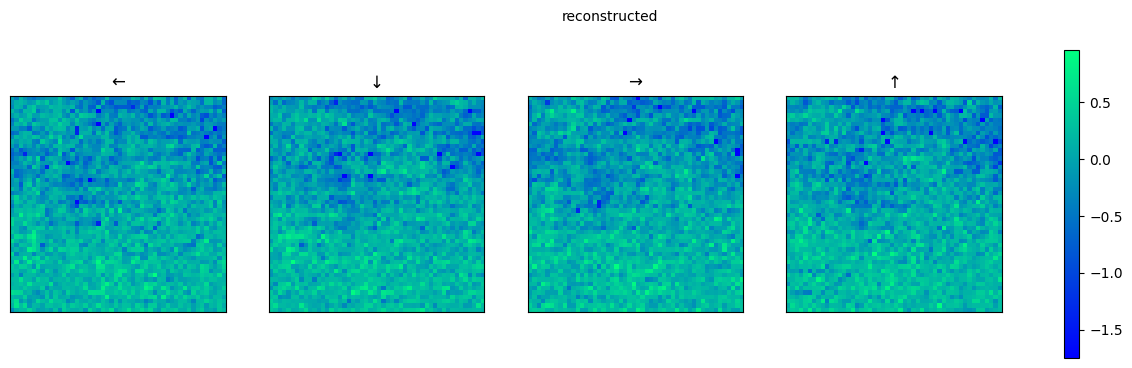

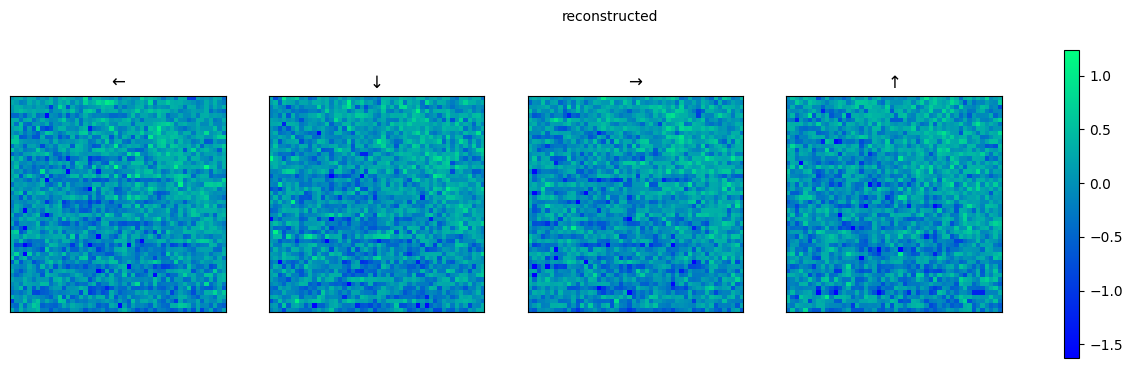

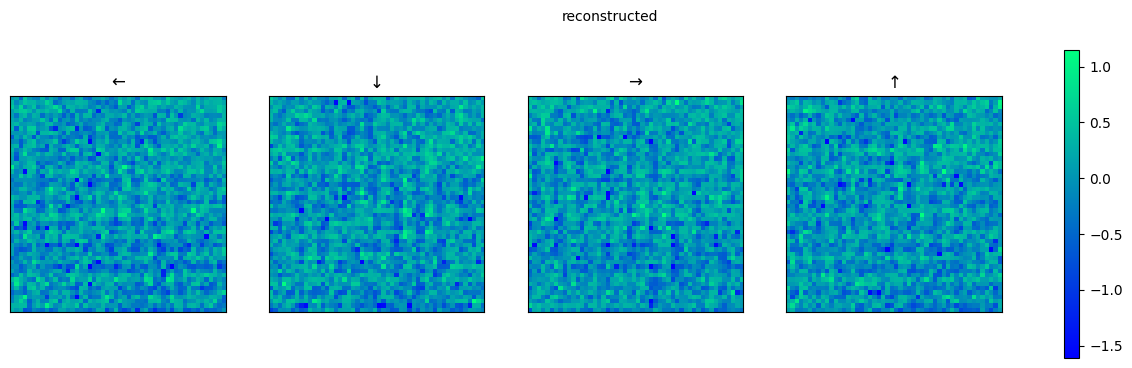

In [16]:
for qtable in [top_left, top_right, bottom_left, center]:
    reconstructed = cs_predict(qtable,sample_ratio=0.7, alpha=1E-5)
    viz_qtable(reconstructed, "reconstructed")

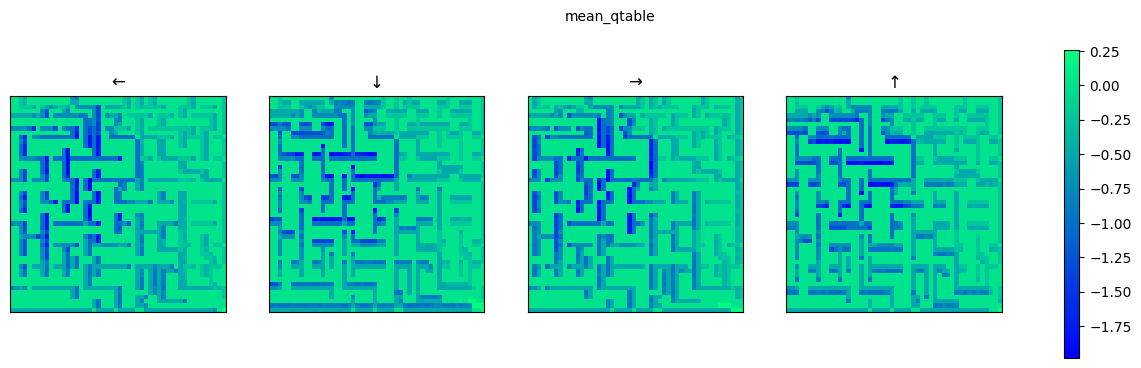

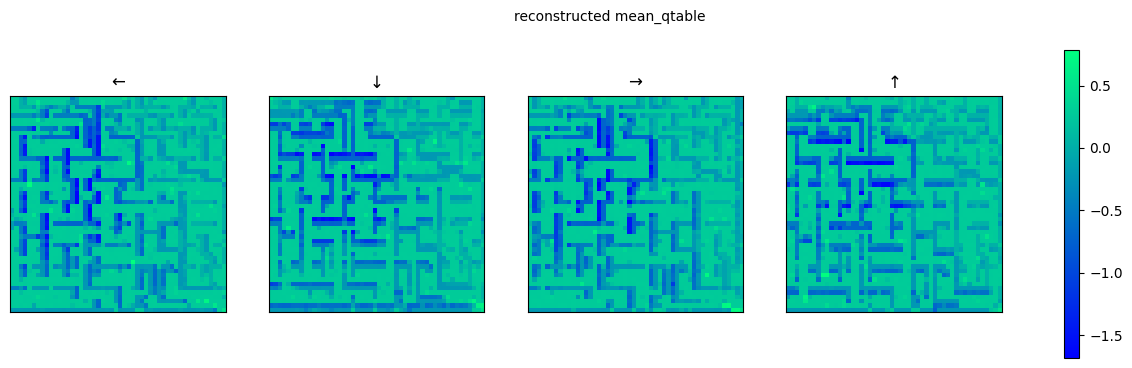

In [17]:
stacked_qtable = np.stack((top_left, top_right, bottom_left, center), axis=-1)

mean_q_table = stacked_qtable.mean(axis=-1)

viz_qtable(mean_q_table, "mean_qtable")

viz_qtable(cs_predict(mean_q_table, sample_ratio=0.9, alpha=1E-6), "reconstructed mean_qtable")